In [30]:
import numpy as np
import torch
import torchOptics.optics as tt
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import torchOptics.metrics as tm
import torchvision
import torchkbnufft


meta = {'wl' : (638e-9), 'dx':(17e-6, 17e-6)}

N = 1024
wl = 500e-9
dx, dy = 1e-6, 1e-6
input_field = torch.zeros((N, N))
input_field[256:768, 256:768] = 1.0
input_field = tt.Tensor(input_field, {'dx':(dx, dy), 'wl':(wl)})
# input_field = input_field.to(torch.complex64)

torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


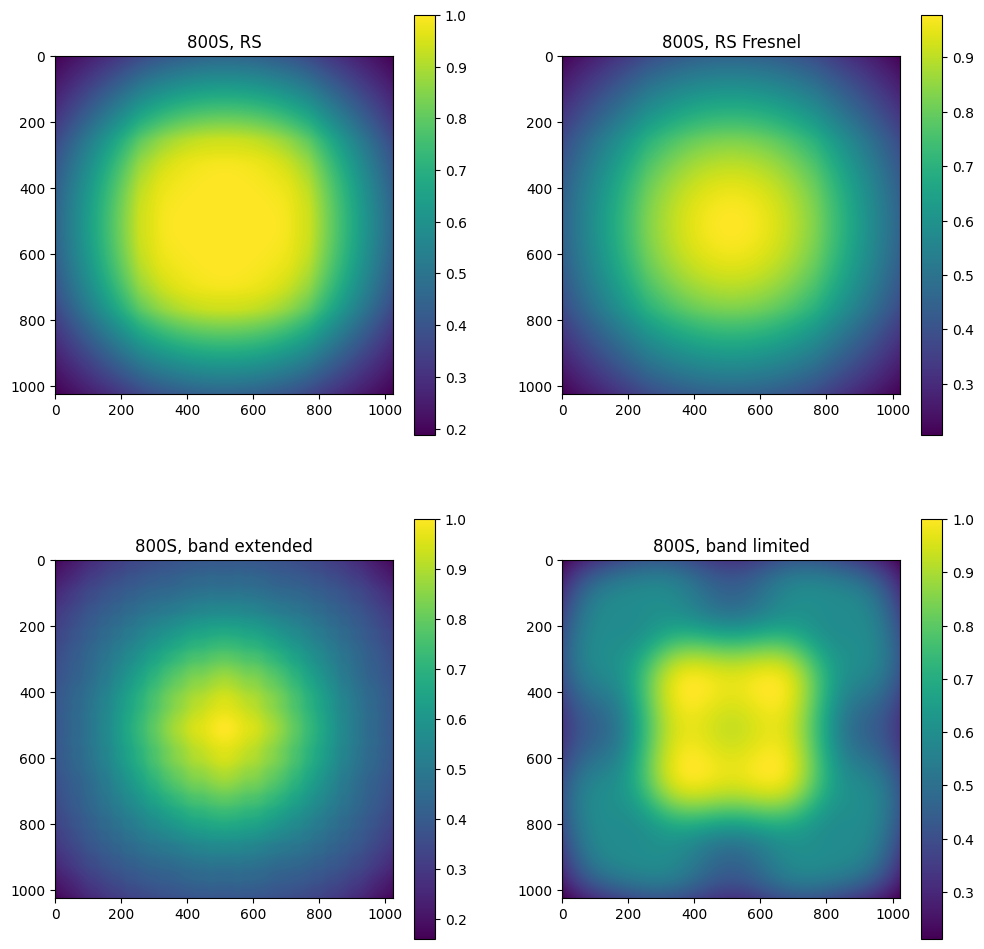

PSNR :  22.86431121826172


In [33]:
import torch
# from torchkbnufft import KbNufft, KbNufftAdjoint
import torchkbnufft.modules as kb
import matplotlib.pyplot as plt

def band_extended_angular_spectrum_method_2d(input_field, λ, dx, dy, N, z):
    # Parameters (adjust as needed)
    # Number of points in source window (per axis)
    # z = 1000 * (N * dx)  # Propagation distance [m]
    total_points = 2 * N # Total points after zero-padding

    # Calculate extended bandwidth (same for x/y in symmetric case)
    f_extend = np.sqrt(N / (2 * λ * z))  # From paper Eq. (6) approximation

    # Generate 2D non-uniform frequency grid
    f_x = torch.linspace(-f_extend, f_extend, total_points)
    f_y = torch.linspace(-f_extend, f_extend, total_points)
    fx_grid, fy_grid = torch.meshgrid(f_x, f_y, indexing='ij')

    # Convert to NUFFT coordinates (radians/sample)
    coordinates_x = 2 * torch.pi * fx_grid.flatten() * dx
    coordinates_y = 2 * torch.pi * fy_grid.flatten() * dy
    # coordinates_x = fx_grid.flatten() * dx
    # coordinates_y = fy_grid.flatten() * dy
    coordinates = torch.stack((coordinates_x, coordinates_y), dim=0)

    # Create 2D input field (square aperture with zero-padding)
    if input_field == None:
        g = torch.zeros((total_points, total_points), dtype=torch.complex64)
        pad = (total_points - N) // 2
        g[pad:pad+N, pad:pad+N] = 1.0
    else:
        padding = torchvision.transforms.Pad((total_points - N) // 2)
        g = padding(input_field)
    # Initialize NUFFT objects for 2D
    nufft_ob = kb.KbNufft(im_size=(total_points, total_points)).cuda()
    adjoint_nufft_ob = kb.KbNufftAdjoint(im_size=(total_points, total_points)).cuda()
    print(g.shape, coordinates.shape)
    # Forward NUFFT (2D uniform spatial to non-uniform frequency)
    G = nufft_ob(
        g.unsqueeze(0).unsqueeze(0).cuda(),  # Add batch, coil, 2D dims
        coordinates.unsqueeze(0).cuda()                   # Add batch dimension
    )

    # Compute 2D transfer function H(f_x, f_y)
    k = 2 * torch.pi / λ
    # Equation(1) in paper
    f_term = (λ**2) * (fx_grid**2 + fy_grid**2)
    # valid for sqrt term is positive
    valid_mask = f_term <= 1.0
    phase = torch.zeros_like(f_term)
    phase[valid_mask] = k * z * torch.sqrt(1 - f_term[valid_mask])
    H = torch.exp(1j * phase).flatten().type(torch.complex64).cuda()

    # Apply transfer function
    A = G * H
    print(A.shape, coordinates.shape)
    # Inverse NUFFT (non-uniform frequency to uniform spatial)
    u = adjoint_nufft_ob(
        A,  # Add batch, coil, 2D dims
        coordinates.unsqueeze(0).cuda()                   # Add batch dimension
    )
    crop = torchvision.transforms.CenterCrop(input_field.shape[-1])
    # Reshape and return output field
    return crop(u.squeeze()), g


def plt_show(field):
    plt.figure(figsize=(6,5))
    plt.imshow((field/field.max()).detach().cpu().numpy())
    plt.colorbar()
    plt.show()


compare_BE_BL(800)

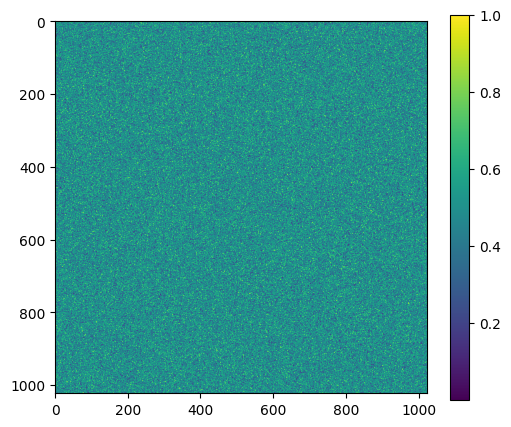

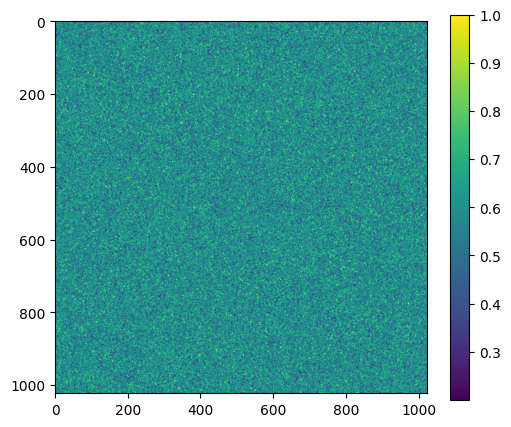

torch.Size([1023, 1023])


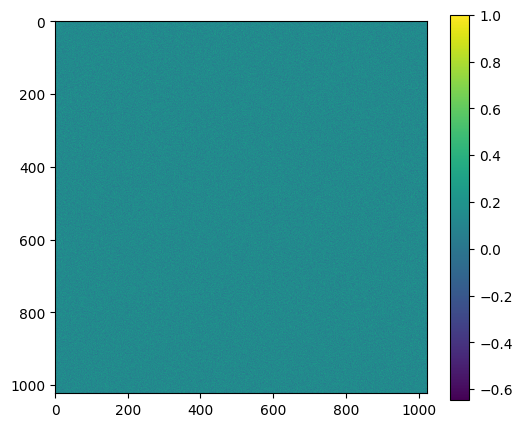

In [14]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

def gaussian_kernel(size: int, sigma: float):
    """Creates a 2D Gaussian kernel."""
    x = torch.arange(size) - size // 2
    y = torch.arange(size) - size // 2
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

def convolve_gaussian(image: torch.Tensor, kernel_size: int = 5, sigma: float = 1.0):
    """Applies Gaussian convolution to a 2D image."""
    kernel = gaussian_kernel(kernel_size, sigma)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)  # Shape for convolution
    
    # Add batch and channel dimensions if needed
    if image.dim() == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
    
    padded_image = F.pad(image, (kernel_size//2, kernel_size//2, kernel_size//2, kernel_size//2), mode='reflect')
    output = F.conv2d(padded_image, kernel, padding=0)
    return output.squeeze()  # Remove extra dimensions


import torch
import torch.fft

def wiener_deconvolution(blurred_image, kernel, snr=0.01):
    """Performs Wiener deconvolution in the frequency domain."""
    # Ensure kernel is the same size as image
    pad_x = (blurred_image.shape[0] - kernel.shape[0]) // 2
    pad_y = (blurred_image.shape[1] - kernel.shape[1]) // 2
    kernel_padded = torch.nn.functional.pad(kernel, (pad_y, pad_y, pad_x, pad_x), mode='constant')

    # Compute FFT of image and kernel
    img_fft = torch.fft.fft2(blurred_image)
    kernel_fft = torch.fft.fft2(kernel_padded)

    # Compute Wiener filter
    print(kernel_padded.shape)
    kernel_conj = torch.conj(kernel_fft)
    denominator = kernel_fft * kernel_conj + snr  # Avoid division by zero
    wiener_filter = kernel_conj / denominator

    # Apply the filter
    restored_fft = img_fft * wiener_filter
    restored_image = torch.fft.ifft2(restored_fft).real  # Get real part
    return restored_image

# Example usage
image = torch.rand(1023, 1023)  # Example blurred image

plt_show(image)
# Example usage
# image = torch.rand(1024, 1024)  # Random image
filtered_image = convolve_gaussian(image, kernel_size=5, sigma=1.0)
plt_show(filtered_image)

kernel = gaussian_kernel(5, 1.0)  # Same kernel used for blurring
deblurred_image = wiener_deconvolution(image, kernel)
plt_show(deblurred_image)

In [15]:
def compare_BE_BL(alpha):
    N = 1024
    input_field = torch.zeros((N, N))
    input_field[256:768, 256:768] = 1.0
    input_field = input_field.to(torch.complex64)
    wl = 500e-9
    dx, dy = 1e-6, 1e-6
    z = alpha * N * dx
    output_field, input_field_ = band_extended_angular_spectrum_method_2d(input_field, wl, dx, dy, N, z)
    # plt_show(input_field.abs())
    
    rs_out = rs_convolution(U0=input_field, wavelength=wl, z=alpha*N*dx, dx=dx, dy=dy)
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    plt.title(f'{alpha}S, RS')
    plt.imshow((rs_out.abs()/rs_out.abs().max()).detach().cpu().numpy())
    plt.colorbar()

    fresnel_out = fresnel_convolution(U0=input_field, wavelength=wl, z=alpha*N*dx, dx=dx, dy=dy)
    plt.subplot(222)
    plt.title(f'{alpha}S, RS Fresnel')
    plt.imshow((fresnel_out.abs()/rs_out.abs().max()).detach().cpu().numpy())
    plt.colorbar()
    
    plt.subplot(223)
    plt.title(f'{alpha}S, band extended')
    plt.imshow((output_field.abs()/output_field.abs().max()).detach().cpu().numpy())
    plt.colorbar()
    meta = {'dx':(dx, dx), 'wl':(wl)}
    input_field = tt.Tensor(input_field, meta=meta)
    tt_sim = tt.simulate(input_field, z, padding=512)
    plt.subplot(224)
    plt.title(f'{alpha}S, band limited')
    plt.imshow((tt_sim.abs()/tt_sim.abs().max()).detach().cpu().numpy())
    plt.colorbar()
    plt.show()
    
    # plt.figure(figsize=(12, 5))
    # plt.subplot(121)
    # plt.title(f'{alpha}S, band extended')
    # plt.imshow(output_field.angle().detach().cpu().numpy())
    # plt.colorbar()
    
    # plt.subplot(122)
    # plt.title(f'{alpha}S, band limited')
    # plt.imshow(tt_sim.angle().detach().cpu().numpy())
    # plt.colorbar()
    
    
    psnr = tt.relativeLoss(output_field.abs().cuda(), tt_sim.abs().cuda(), tm.get_PSNR)
    print('PSNR : ', psnr)

In [41]:
def rs_convolution(U0, wavelength, z, dx, dy):
    """
    Convolution implementation using FFT
    """
    k = 2 * torch.pi / wavelength
    Nx, Ny = U0.shape
    
    # Spatial coordinates
    x = dx * (torch.arange(Nx) - Nx//2)
    y = dy * (torch.arange(Ny) - Ny//2)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    
    # RS kernel calculation
    r = torch.sqrt(X**2 + Y**2 + z**2)
    h = (z / (1j * wavelength)) * torch.exp(1j * k * r) / (r**2)
    # h = torch.fft.ifftshift(h)
    # FFT-based convolution
    U0_padded = torch.nn.functional.pad(U0, (Ny//2, Ny//2, Nx//2, Nx//2))
    h_padded = torch.nn.functional.pad(h, (Ny//2, Ny//2, Nx//2, Nx//2))
    
    U1_padded = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(torch.fft.fft2(U0_padded)) * torch.fft.fftshift(torch.fft.fft2(h_padded))))
    # print(U1_padded.shape)
    crop = torchvision.transforms.CenterCrop(U0.shape[-1])
    return crop(U1_padded)
    # return U1_padded


def fresnel_convolution(U0, wavelength, z, dx, dy):
    """
    Fresnel approximation using quadratic phase convolution
    """
    k = 2 * torch.pi / wavelength
    Nx, Ny = U0.shape
    
    # Spatial coordinates
    x = dx * (torch.arange(Nx) - Nx//2)
    y = dy * (torch.arange(Ny) - Ny//2)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    
    # Fresnel kernel
    h = (np.exp(1j * k * z) / (1j * wavelength * z)) * \
        torch.exp(1j * k * (X**2 + Y**2) / (2 * z))
    
    # FFT-based convolution
    U0_padded = torch.nn.functional.pad(U0, (Ny//2, Ny//2, Nx//2, Nx//2))
    h_padded = torch.nn.functional.pad(h, (Ny//2, Ny//2, Nx//2, Nx//2))
    
    U1_padded = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(torch.fft.fft2(U0_padded)) * torch.fft.fftshift(torch.fft.fft2(h_padded))))
    # print(U1_padded.shape)
    crop = torchvision.transforms.CenterCrop(U0.shape[-1])
    return crop(U1_padded)

    U0_padded = U0
    h_padded = h
    plt_show(U0_padded.abs())
    plt_show(h_padded.abs())
    plt_show(h_padded.angle())
    U1_padded = torch.fft.ifft2(torch.fft.fft2(U0_padded) * torch.fft.fft2(h_padded))
    print(U1_padded.shape)
    crop = torchvision.transforms.CenterCrop(U0.shape[-1])
    return crop(U1_padded)

In [3]:
alpha = 4
N = 1024
wl = 500e-9
dx, dy = 1e-6, 1e-6
input_field = torch.zeros((N, N))
input_field[256:768, 256:768] = 1.0
input_field = tt.Tensor(input_field, {'dx':(dx, dy), 'wl':(wl)})
input_field = input_field.to(torch.complex64)
# rs_conv_result = rs_convolution(U0=input_field, wavelength=wl, z=alpha*N*dx, dx=dx, dy=dy)
# plt_show(rs_conv_result.abs())
tt_sim = tt.simulate(input_field, 800*N*dx, padding = 10000)

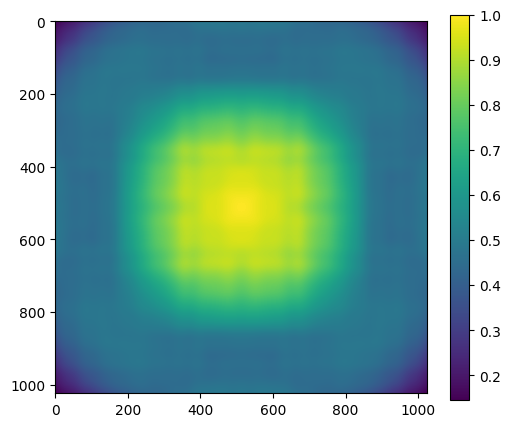

In [5]:
plt_show(tt_sim.abs())

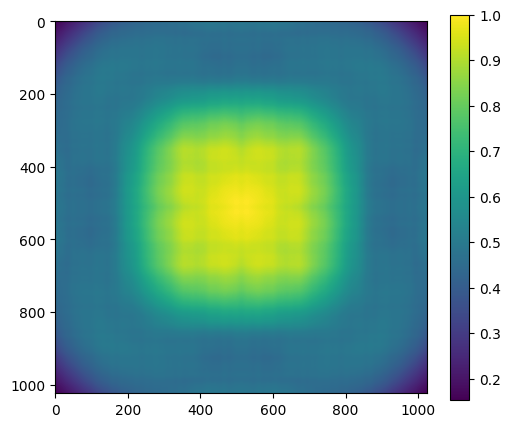

In [6]:
tt_sim = tt.simulate(input_field, 800*N*dx, padding = 20000)
plt_show(tt_sim.abs())

torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


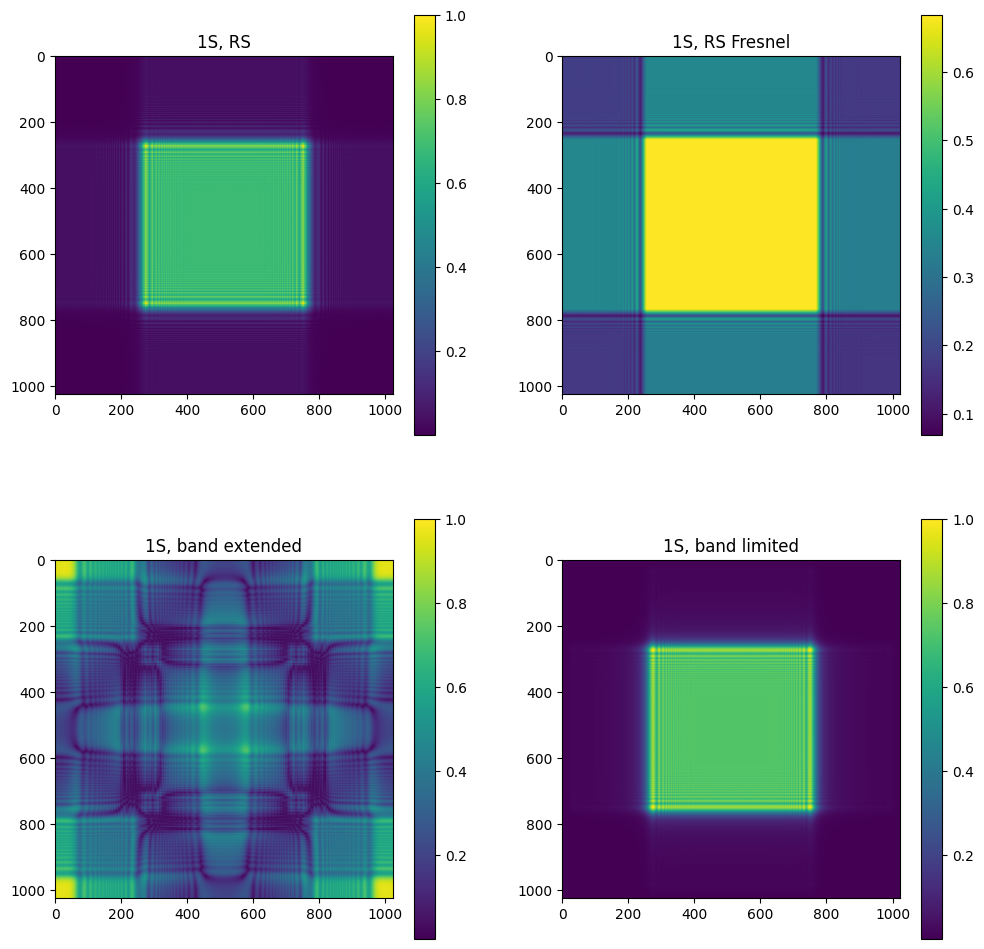

PSNR :  9.737438201904297
torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


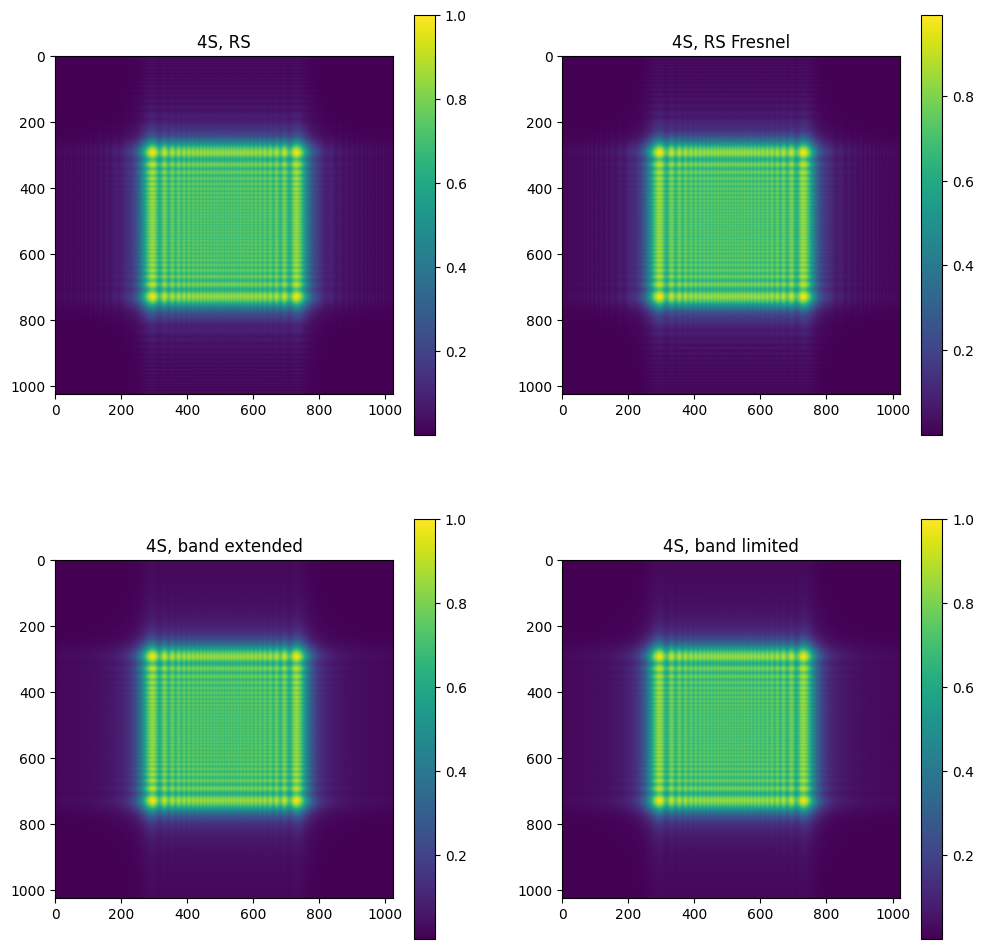

PSNR :  69.39364624023438
torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


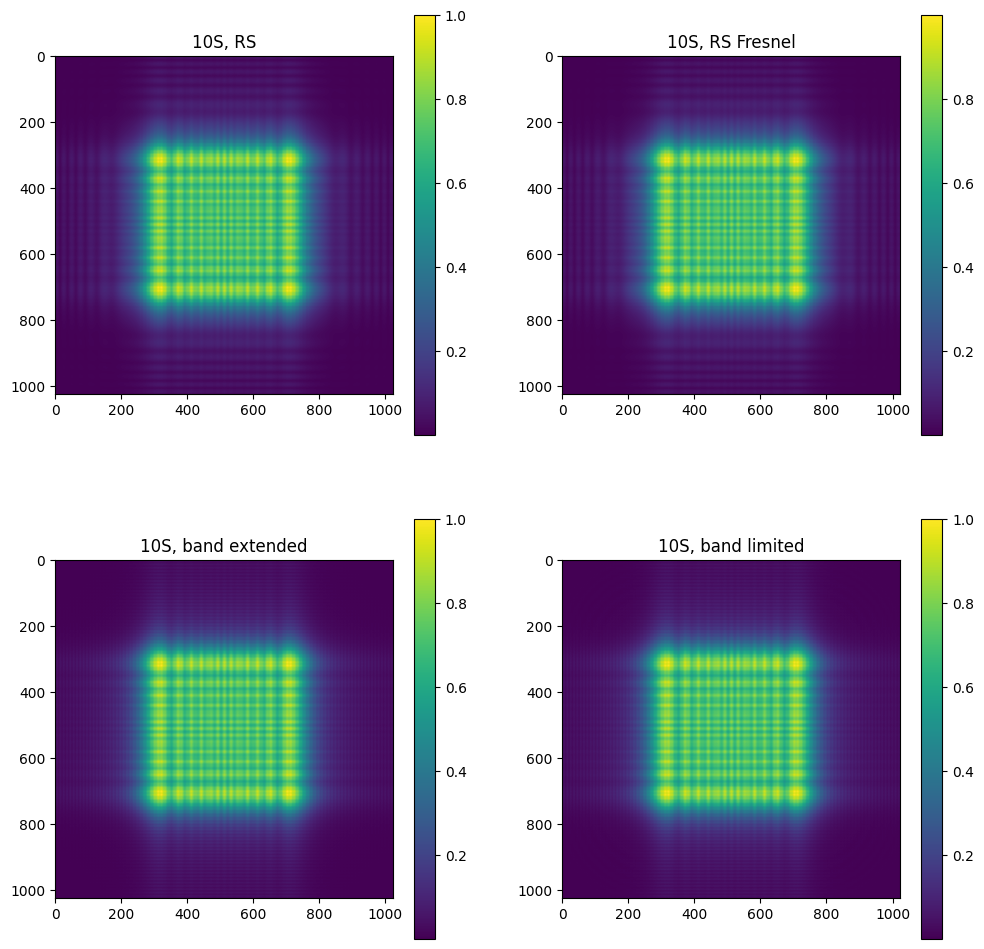

PSNR :  64.10576629638672
torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


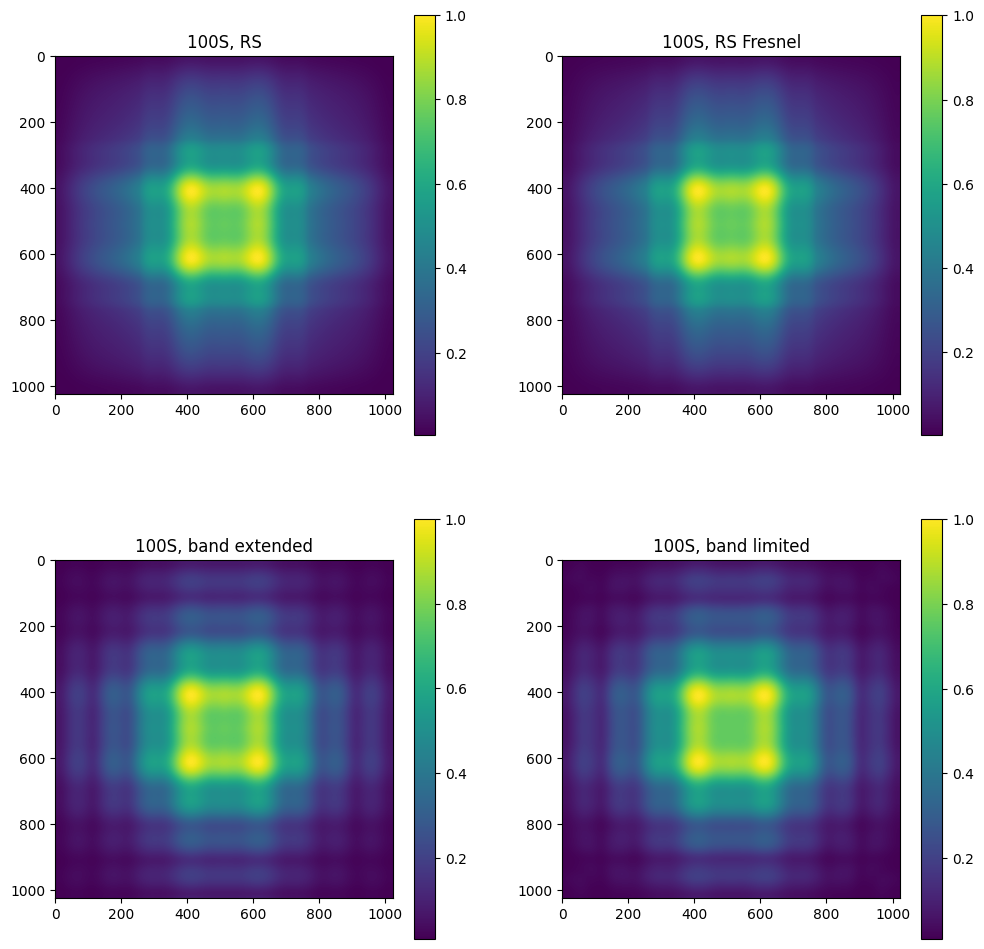

PSNR :  47.78459930419922
torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


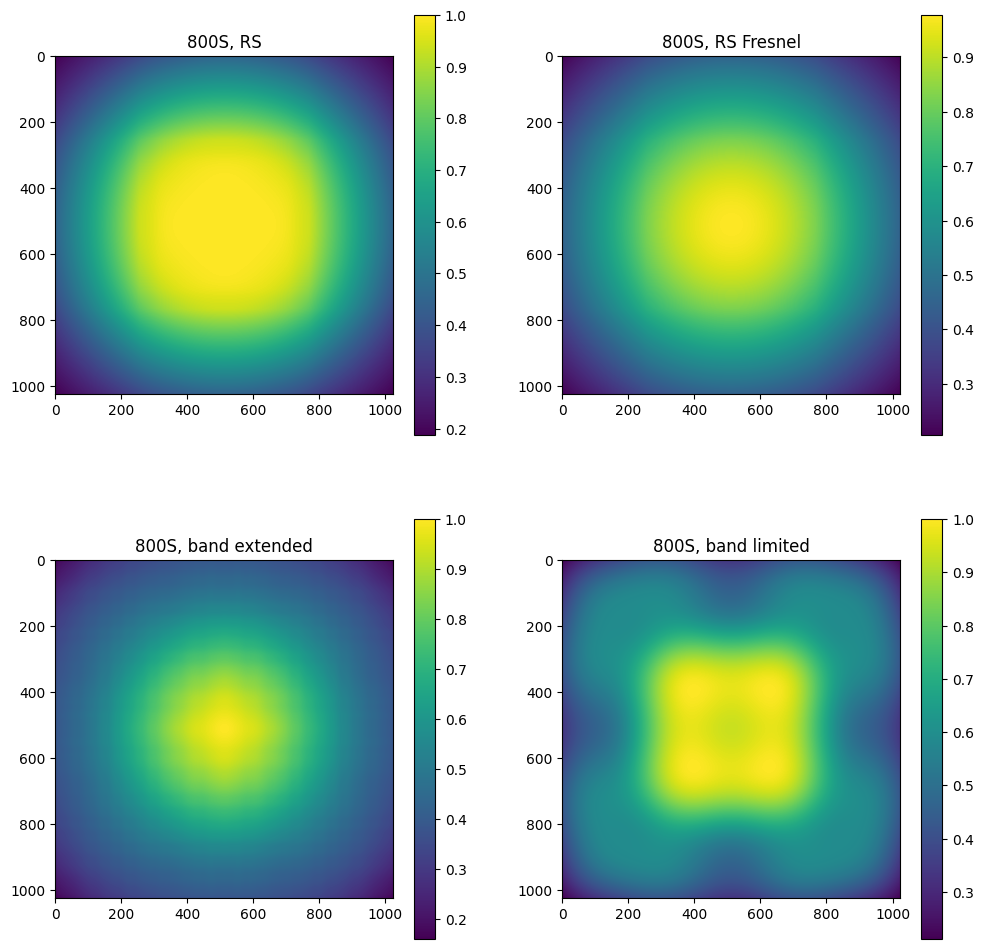

PSNR :  22.86431121826172
torch.Size([2048, 2048]) torch.Size([2, 4194304])
torch.Size([1, 1, 4194304]) torch.Size([2, 4194304])


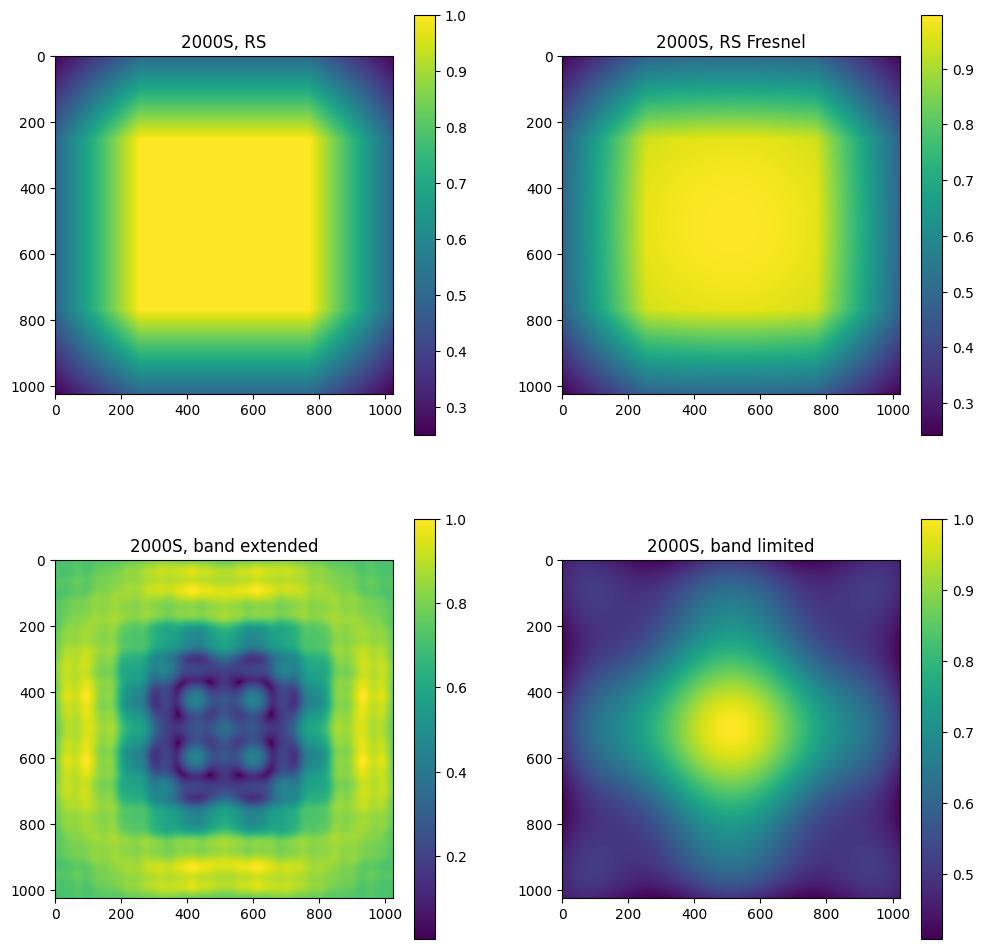

PSNR :  8.986418724060059


In [42]:
S_list = [1, 4, 10, 100, 800, 2000]
for S in S_list:
    compare_BE_BL(S)

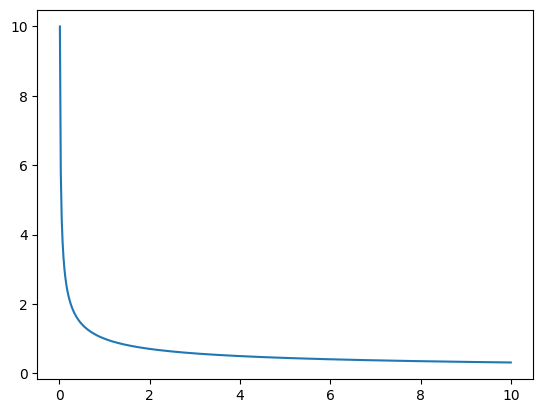

In [7]:
x = np.linspace(-10, 10, 1000)+1e-10
fx = 1/np.sqrt(x)
plt.plot(x, fx)
plt.show()

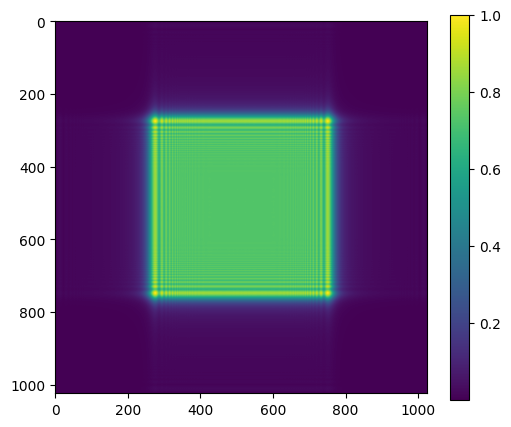

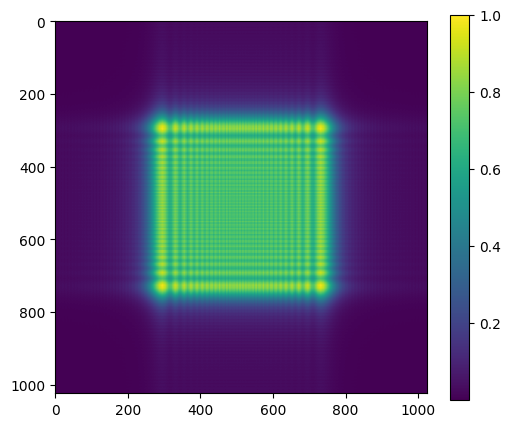

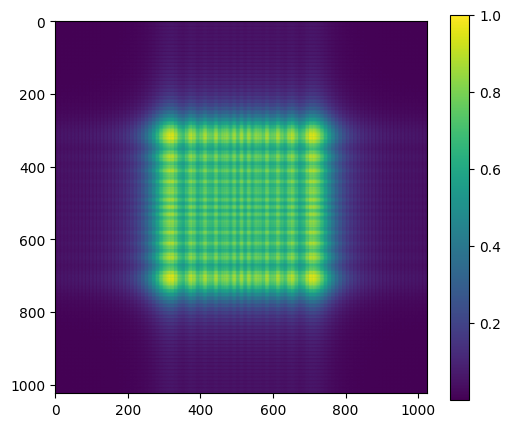

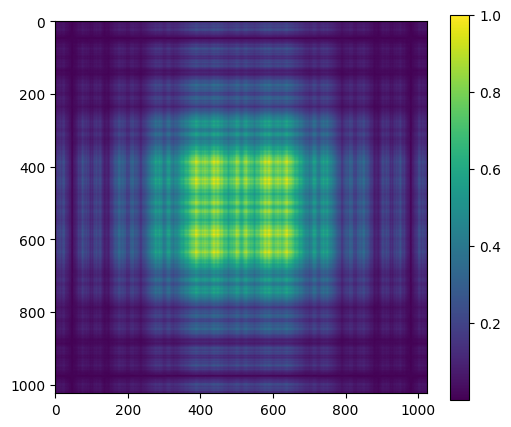

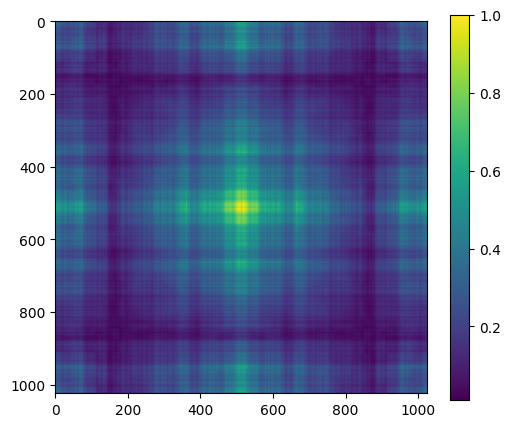

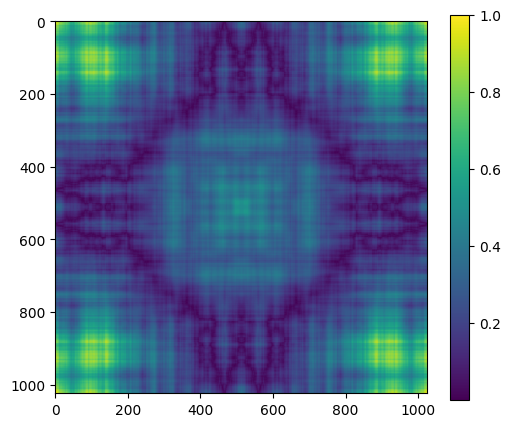

In [39]:
padding = torchvision.transforms.Pad(N//2)
crop = torchvision.transforms.CenterCrop(1024)
S_list = [1, 4, 10, 100, 800, 2000]
for S in S_list:
    plt_show(angular_spectrum(crop(padding(input_field)), wl, S*dx*N, dx, dy).abs())

In [44]:
dx = 17e-6
wl = 450e-9
L = dx*1024
z = dx*L/wl
print(z)

0.6576355555555555
